# Instrumental, Genre and Mood Detection in Music with Deep Learning

This tutorial shows how different Convolutional Neural Network architectures are used for:
* Instrumental vs. Vocal Detection:  detecting whether a piece of music is instrumental or contains vocals
* Genre Classification
* Mood Recognition

The data set used is the [MagnaTagATune Dataset](http://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset), but a smaller subset of it, with only 1 sample excerpt of each of the original audio files.

It consists of 5405 files, each 30 seconds long. 

The annotations for this dataset contain a multitude of tags, including some that hint at whether the file is instrumental or vocal. (see [Create 2 classes from a list of tags](#Create-2-classes-from-a-list-of-tags) below)

### Requirements

* Python 3.5
* Keras >= 2.1.1
* Tensorflow
* scikit-learn >= 0.18
* Pandas
* Librosa
* MatplotLib

### Table of Contents

This tutorial contains:
* Loading and Preprocessing of Audio files
* Loading class files from CSV and using Label Encoder
* Audio Preprocessing: Generating log Mel spectrograms
* Standardization of Data
* Convolutional Neural Networks
* Train/Test set split

* Instrumental vs. Vocal Detection
* Genre Classification
* Mood Recognition

You can execute the following code blocks by pressing SHIFT+Enter consecutively.

### Download Data

The (subsampled) data set can be downloaded from [here](https://owncloud.tuwien.ac.at/index.php/s/hivOGXKoUQtacbo).

Please unzip it.

Set the path to the unpacked folder in the next box:

In [1]:
import os

DATA_PATH = '/home/tlidy/data/MagnaTagATune'
AUDIO_PATH = os.path.join(DATA_PATH, 'audio')
META_PATH = os.path.join(DATA_PATH, 'metadata')

#NPZ_FILE = '/home/tlidy/data/mel_spectrogram_segments_96x1366.npz'

In [2]:
# General Imports

import argparse
import csv
import datetime
import glob
import math
import sys
import time
import numpy as np
import pandas as pd # Pandas for reading CSV files and easier Data handling in preparation

# Deep Learning

import keras
from keras import optimizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, merge
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU

# Machine Learning preprocessing and evaluation

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

Using TensorFlow backend.


In [3]:
# local imports for audio reading and processing
import audio_spectrogram as rp
from audiofile_read import audiofile_read

## Load the Metadata

The tab-separated file contains pairs of filename TAB class.

In [4]:
csv_file = os.path.join(META_PATH,'annotations_final_subsample.csv')

# we select the last column (-1) as the index column (= filename)
metadata = pd.read_csv(csv_file, index_col=0, sep='\t')
metadata.head(10)

,clip_id,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,...,female singer,rap,metal,hip hop,quick,water,baroque,women,fiddle,english
mp3_path,,,,,,,,,,,,,,,,,,,,,
d/ambient_teknology-the_all_seeing_eye_project-01-cyclops-262-291.mp3,1119,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-02-all_seeing_eye-175-204.mp3,6021,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-03-black-175-204.mp3,11847,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-04-confusion_says-88-117.mp3,17119,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-05-the_beholder-291-320.mp3,25118,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-06-cyead-378-407.mp3,26533,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-07-telekonology-117-146.mp3,33637,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0/american_bach_soloists-j_s__bach__cantatas_volume_v-01-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_i_sinfonia-117-146.mp3,29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0/american_bach_soloists-j_s__bach__cantatas_volume_v-02-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_ii_recitative__gleichwie_der_regen_und_schnee-30-59.mp3,5864,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# remove the unneeded column "clip_id"
cols = "clip_id"
metadata.drop(cols,axis=1,inplace=True)

metadata.head()

,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,clasical,...,female singer,rap,metal,hip hop,quick,water,baroque,women,fiddle,english
mp3_path,,,,,,,,,,,,,,,,,,,,,
d/ambient_teknology-the_all_seeing_eye_project-01-cyclops-262-291.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-02-all_seeing_eye-175-204.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-03-black-175-204.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-04-confusion_says-88-117.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-05-the_beholder-291-320.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 1) Instrumental vs. Vocal Detection

this is a binary classification task (output decision is between 0 and 1)

### Create 2 classes from a list of tags

There are plenty of "tags" in this data set which hint at wether a track is "vocal" or "instrumental". We group these tags and finally come up with 1 boolean column saying whether a track is "vocal" or "instrumental".

In [6]:
tags_vocal = ['singer', 'female singing', 'female opera', 'male vocal', 'vocals', 'men', 'female', 'female voice', 'voice', 'male voice', 'girl', 'chanting', 'talking', 'choral', 'male singer', 'man singing', 'male opera', 'chant', 'man', 'female vocal', 'male vocals', 'vocal', 'woman', 'woman singing', 'singing', 'female vocals', 'voices', 'choir', 'female singer', 'women', 'choir', 'women']

tags_instrumental = ['instrumental', 'no voice', 'no voices', 'no vocals', 'no vocal', 'no singing', 'no singer']

In [7]:
metadata[tags_vocal].head()

,singer,female singing,female opera,male vocal,vocals,men,female,female voice,voice,male voice,...,woman,woman singing,singing,female vocals,voices,choir,female singer,women,choir,women
mp3_path,,,,,,,,,,,,,,,,,,,,,
d/ambient_teknology-the_all_seeing_eye_project-01-cyclops-262-291.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-02-all_seeing_eye-175-204.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-03-black-175-204.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-04-confusion_says-88-117.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-05-the_beholder-291-320.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# set vocal to True of any of the tags_vocal are 1
gt_vocal = metadata[tags_vocal].any(axis=1)
gt_vocal.head()

mp3_path
d/ambient_teknology-the_all_seeing_eye_project-01-cyclops-262-291.mp3           False
d/ambient_teknology-the_all_seeing_eye_project-02-all_seeing_eye-175-204.mp3    False
d/ambient_teknology-the_all_seeing_eye_project-03-black-175-204.mp3             False
d/ambient_teknology-the_all_seeing_eye_project-04-confusion_says-88-117.mp3     False
d/ambient_teknology-the_all_seeing_eye_project-05-the_beholder-291-320.mp3      False
dtype: bool

In [9]:
# set instrumental to True of any of the tags_instrumental are 1
gt_instrumental = metadata[tags_instrumental].any(axis=1)
gt_instrumental.head()

mp3_path
d/ambient_teknology-the_all_seeing_eye_project-01-cyclops-262-291.mp3           False
d/ambient_teknology-the_all_seeing_eye_project-02-all_seeing_eye-175-204.mp3    False
d/ambient_teknology-the_all_seeing_eye_project-03-black-175-204.mp3             False
d/ambient_teknology-the_all_seeing_eye_project-04-confusion_says-88-117.mp3     False
d/ambient_teknology-the_all_seeing_eye_project-05-the_beholder-291-320.mp3       True
dtype: bool

<b>We can only use the tag if EITHER instrumental OR vocal is True.</b><br>
If both of them are True or both of them are False, we cannot trust the groundtruth data. Ergo we have to remove these and retain only the others.

In [10]:
retain = np.logical_xor(gt_vocal,gt_instrumental)
retain.head()

mp3_path
d/ambient_teknology-the_all_seeing_eye_project-01-cyclops-262-291.mp3           False
d/ambient_teknology-the_all_seeing_eye_project-02-all_seeing_eye-175-204.mp3    False
d/ambient_teknology-the_all_seeing_eye_project-03-black-175-204.mp3             False
d/ambient_teknology-the_all_seeing_eye_project-04-confusion_says-88-117.mp3     False
d/ambient_teknology-the_all_seeing_eye_project-05-the_beholder-291-320.mp3       True
dtype: bool

In [11]:
n_orig = len(gt_vocal)

n_retain = sum(retain)

print("From originally", n_orig, "input examples, we can only retain",n_retain, "trusted ones in our groundtruth")

From originally 3023 input examples, we can only retain 959 trusted ones in our groundtruth


In the end we cut from gt_vocal only the exampls to retain. If they are True they are vocal, if they are False, they are instrumental:

In [12]:
gt_final = gt_vocal[retain]
gt_final.head(9)

mp3_path
d/ambient_teknology-the_all_seeing_eye_project-05-the_beholder-291-320.mp3                                                                                                                   False
0/american_bach_soloists-j_s__bach__cantatas_volume_v-03-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_iii_recitative_and_litany__mein_gott_hier_wird_mein_herze_sein-88-117.mp3     True
0/american_bach_soloists-j_s__bach__cantatas_volume_v-07-weinen_klagen_sorgen_zagen_bwv_12_ii_chorus__weinen_klagen_sorgen_zagen-262-291.mp3                                                  True
0/american_bach_soloists-j_s__bach__cantatas_volume_v-08-weinen_klagen_sorgen_zagen_bwv_12_iii_recitative__wir_mussen_durch_viel_truebsal-0-29.mp3                                            True
0/american_bach_soloists-j_s__bach__cantatas_volume_v-09-weinen_klagen_sorgen_zagen_bwv_12_iv_aria__kreuz_und_krone_sind_verbunden-59-88.mp3                                                  True
0/american_bach_

In [13]:
print(str(sum(gt_final)) + " vocal tracks")

671 vocal tracks


In [14]:
print(str(sum(np.logical_not(gt_final))) + " instrumental tracks")

288 instrumental tracks


<b>Create two lists: one with filenames and one with associated classes</b>

In [15]:
# index in list of strings
filelist = gt_final.index.tolist()
# convert boolean to int and store in other list
classes = (gt_final * 1).tolist()

In [16]:
filelist[0:5]

['d/ambient_teknology-the_all_seeing_eye_project-05-the_beholder-291-320.mp3',
 '0/american_bach_soloists-j_s__bach__cantatas_volume_v-03-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_iii_recitative_and_litany__mein_gott_hier_wird_mein_herze_sein-88-117.mp3',
 '0/american_bach_soloists-j_s__bach__cantatas_volume_v-07-weinen_klagen_sorgen_zagen_bwv_12_ii_chorus__weinen_klagen_sorgen_zagen-262-291.mp3',
 '0/american_bach_soloists-j_s__bach__cantatas_volume_v-08-weinen_klagen_sorgen_zagen_bwv_12_iii_recitative__wir_mussen_durch_viel_truebsal-0-29.mp3',
 '0/american_bach_soloists-j_s__bach__cantatas_volume_v-09-weinen_klagen_sorgen_zagen_bwv_12_iv_aria__kreuz_und_krone_sind_verbunden-59-88.mp3']

In [17]:
classes[0:5]

[0, 1, 1, 1, 1]

In [18]:
# convert to Numpy array as needed by Keras
classes = np.array(classes)
classes[0:5]

array([0, 1, 1, 1, 1])

## Load the Audio Files

#### Function to analyze audio files and get small or large spectrogram excerpts

In [19]:
def create_spectrograms(filelist, n_mel_bands=40, frames=80, return_example=False):

    list_spectrograms = [] # spectrograms are put into a list first

    # some FFT parameters
    fft_window_size=512
    fft_overlap = 0.5
    hop_size = int(fft_window_size*(1-fft_overlap))
    segment_size = fft_window_size + (frames-1) * hop_size # segment size for desired # frames

    print("Reading and processing", len(filelist), "audio files")
    
    for filename in filelist:
        print(".", end='')
        filepath = os.path.join(AUDIO_PATH, filename)
        samplerate, samplewidth, wavedata = audiofile_read(filepath,verbose=False)
        sample_length = wavedata.shape[0]

        # make Mono (in case of multiple channels / stereo)
        if wavedata.ndim > 1:
            wavedata = np.mean(wavedata, 1)

        # take only a segment; choose start position:
        #pos = 0 # beginning
        pos = int(wavedata.shape[0]/2 - segment_size/2) # center minus half segment size
        wav_segment = wavedata[pos:pos+segment_size]

        # 1) FFT spectrogram 
        spectrogram = rp.calc_spectrogram(wav_segment,fft_window_size,fft_overlap)

        # 2) Transform to perceptual Mel scale (uses librosa.filters.mel)
        spectrogram = rp.transform2mel(spectrogram,samplerate,fft_window_size,n_mel_bands)

        # 3) Log 10 transform
        spectrogram = np.log10(spectrogram)

        list_spectrograms.append(spectrogram)

    print("\nConverting to big data array...")
    # a list of many spectrograms is made into 1 big array with 3 dimensions
    # + convert the input data to the right data type used by Keras Deep Learning (GPU)
    data = np.array(list_spectrograms, dtype=K.floatx())

    # replace Inf values:
    # as in our preprocessing some files generated an Inf value in the log10 computation, we replace those by 0:

    data[np.isinf(data)] = 0

    print("done.")
    
    # just for illustration purposes, return the last wav file and its spectrogram and audio data
    if return_example:
        return data, wav_segment, spectrogram, segment_size, samplerate, samplewidth
    
    return data

#### Define desired output parameters

In [20]:
# small spectrograms
#n_mel_bands = 40   # y axis
#frames = 80        # x axis

# large  spectrograms
n_mel_bands = 96   # y axis
frames = 683        # x axis

# extra large  spectrograms
#n_mel_bands = 96   # y axis
#frames = 1366        # x axis

In [21]:
#data = create_spectrograms(filelist, n_mel_bands, frames)
 
# get some extra data for illustration
data, wav_segment, spectrogram, segment_size, samplerate, samplewidth = create_spectrograms(filelist, n_mel_bands, frames, return_example=True)

Reading and processing 959 audio files
............................................................................................................................................................................................................................................................................................................................

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Converting to big data array...
done.


In [30]:
# OPTIONAL: store audio features for faster reload later

save_features = True

if save_features:
    FEAT_FILE = os.path.join(DATA_PATH, "spectrograms_instrumental.npz")
    np.savez(FEAT_FILE, data = data, filenames = filelist)
    print("Features stored to " + FEAT_FILE)

Features stored to /home/tlidy/data/MagnaTagATune/spectrograms_instrumental.npz


### Show Waveform and Spectrogram (just for illustration)

In [26]:
samplerate, samplewidth

(22050, 2)

In [27]:
wav_segment

array([-0.00286865, -0.02416992,  0.00906372, ...,  0.04193115,
        0.05844116,  0.06524658])

In [28]:
spectrogram.shape

(96, 683)

In [ ]:
print("An audio segment is", round(float(segment_size) / samplerate, 2), "seconds long")

In [31]:
data.shape

(959, 96, 683)

NameError: name 'filename' is not defined

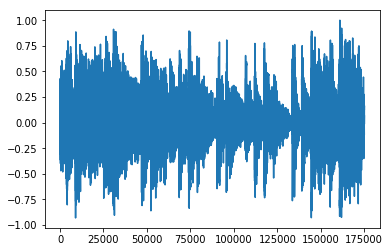

In [32]:
# you can skip this if you do not have matplotlib installed

import matplotlib.pyplot as plt
%matplotlib inline 

# show 1 sec wave segment
plt.plot(wav_segment)
filename

In [ ]:
# show spectrogram
fig = plt.imshow(spectrogram, origin='lower', aspect='auto')
fig.set_cmap('jet')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

## Standardization

<b>Always standardize</b> the data before feeding it into the Neural Network!

We use <b>Zero-mean Unit-variance standardization</b> (also known as Z-score normalization).
Here, we use <b>attribute-wise standardization</b>, i.e. each pixel is standardized individually, as opposed to computing a single mean and single standard deviation of all values.

('Flat' standardization would also be possible, but we have seen benefits of attribut-wise standardization in our experiments).

We use the StandardScaler from the scikit-learn package for our purpose.
As it works typically on vector data, we have to vectorize (i.e. reshape) our matrices first.

In [33]:
def standardize(data):
    # vectorize before standardization (cause scaler can't do it in that format)
    N, ydim, xdim = data.shape
    data = data.reshape(N, xdim*ydim)

    # standardize
    scaler = preprocessing.StandardScaler()
    data = scaler.fit_transform(data)

    # reshape to original shape
    return data.reshape(N, ydim, xdim)

In [34]:
data = standardize(data)

# Convolutional Neural Networks

A Convolutional Neural Network (ConvNet or CNN) is a type of (deep) Neural Network that is well-suited for 2D axes data, such as images or spectrograms, as it is optimized for learning from spatial proximity. Its core elements are 2D filter kernels which essentially learn the weights of the Neural Network, and downscaling functions such as Max Pooling.

A CNN can have one or more Convolution layers, each of them having an arbitrary number of N filters (which define the depth of the CNN layer), following typically by a pooling step, which aggregates neighboring pixels together and thus reduces the image resolution by retaining only the maximum values of neighboring pixels.

## Preparing the Data

### Adding the channel

As CNNs were initially made for image data, we need to add a dimension for the color channel to the data. RGB images typically have a 3rd dimension with the color. 

<b>Spectrograms, however, are considered like greyscale images, as in the previous tutorial.
Likewise we need to add an extra dimension for compatibility with the CNN implementation.</b>

For greyscale images, we add the number 1 as the depth of the additional dimension of the input shape (for RGB color images, the number of channels is 3).

<i>Note on Tensorflow vs. Theano:</i>

In Theano, traditionally the color channel was the <b>first</b> dimension in the image shape. 
In Tensorflow, the color channel is the <b>last</b> dimension in the image shape. 

This can be configured in ~/.keras/keras.json: "image_dim_ordering": "th" or "tf" (for Theano or Tensorflow) *or* with "image_data_format" set to "channels_first" or "channels_last".

Tensorflow is now the default image ordering for Kears ("tf" and/or "channels_last").
To be on the safe side, we added the if statement below.

In [33]:
keras.backend.image_data_format()

'channels_last'

In [69]:
def add_channel(data, n_channels=1):
    # n_channels: 1 for grey-scale, 3 for RGB, but usually already present in the data
    
    N, ydim, xdim = data.shape

    if keras.backend.image_data_format() == 'channels_last':  # TENSORFLOW
        # Tensorflow ordering (~/.keras/keras.json: "image_dim_ordering": "tf")
        data = data.reshape(N, ydim, xdim, n_channels)
    else: # THEANO
        # Theano ordering (~/.keras/keras.json: "image_dim_ordering": "th")
        data = data.reshape(N, n_channels, ydim, xdim)
        
    return data

In [ ]:
data = add_channel(data, n_channels=1)
data.shape

In [36]:
# we store the new shape of the images in the 'input_shape' variable.
# take all dimensions except the 0th one (which is the number of files)
input_shape = data.shape[1:]  
input_shape

(96, 683, 1)

### Train & Test Set Split

We split the original full data set into two parts: Train Set (75%) and Test Set (25%).

Note: 
For demo purposes we use only 1 split here. A better way to do it is to use **Cross-Validation**, doing the split multiple times, iterating training and testing over the splits and averaging the results.

In [37]:
testset_size = 0.25 # % portion of whole data set to keep for testing, i.e. 75% is used for training

In [38]:
# Stratified Split retains the class balance in both sets

splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(data, classes)

for train_index, test_index in splits:
    print("TRAIN INDEX:", train_index)
    print("TEST INDEX:", test_index)
    train_set = data[train_index]
    test_set = data[test_index]
    train_classes = classes[train_index]
    test_classes = classes[test_index]
# Note: this for loop is only executed once if n_splits==1

TRAIN INDEX: [135 957 350 397 651 154 704 255 811 881 937 921 229 635 839 643   2 619
 299 225 388 400 717 444 736 673 675 548 731 850 401 112 608  71 791  76
 281 721 545 538 155 753 206  41 527 856 491 745 366 756 720 227 218 836
 103 711  72 878  42 144 447 349 589 710 362 203 376 864 782 226 302 220
 379 773 256 555 476 231  49  51 601 458 744 623 906 685 136 730 115 781
 747 628 869 441 148 728 264 934  37 479 599 237 134 493 557 265 687  88
 363 884 179 201 195 578 166 342 797 339 842 284 924 416 145 382  22  80
 851 927  60 952 912 292 378 634 287 263 181 316 954  53 141 928 278 348
 563 890 735 553  93 385 564 294 824 371 841 585 198 757 700 876   3 558
 953 748 678 903 544 920 784  16 832 466 448 883 190 187 200 483 650 654
 128 442  75 752 914 894 776 386 100  30 178   1 249 420 129 101 497 429
  61 888 450 396 480 172 923 885 694 693 916 373 909 273 624 621 331  55
  39 570 104 234 785 672  86 270 475  54  95 569 146  59 603 521 543 568
 403 726  47 702 577  94  12 216 267 7

In [39]:
print(train_set.shape)
print(test_set.shape)

(719, 96, 683, 1)
(240, 96, 683, 1)


In [40]:
print("Class Counts: Class 0:", sum(train_classes==0), "Class 1:", sum(train_classes))

Class Counts: Class 0: 216 Class 1: 503


# Creating CNN Models in Keras

## Compact CNN

This is a 5 layer Convolutional Neural Network inspired and adapted from Keunwoo Choi (https://github.com/keunwoochoi/music-auto_tagging-keras)

In [48]:
data.shape

(959, 96, 683, 1)

In [86]:
def CompactCNN(input_shape, nb_conv, nb_filters, n_mels, normalize, nb_hidden, dense_units, 
               output_shape, activation, dropout, multiple_segments=False, graph_model=False, input_tensor=None):
    
    melgram_input = Input(shape=input_shape)

    if n_mels >= 256:
        poolings = [(2, 4), (4, 4), (4, 5), (2, 4), (4, 4)]
    elif n_mels >= 128:
        poolings = [(2, 4), (4, 4), (2, 5), (2, 4), (4, 4)]
    elif n_mels >= 96:
        poolings = [(2, 4), (3, 4), (2, 5), (2, 4), (4, 4)]
    elif n_mels >= 72:
        poolings = [(2, 4), (3, 4), (2, 5), (2, 4), (3, 4)]
    elif n_mels >= 64:
        poolings = [(2, 4), (2, 4), (2, 5), (2, 4), (4, 4)]

    # Determine input axis
    if keras.backend.image_dim_ordering() == 'th':
        channel_axis = 1
        freq_axis = 2
        time_axis = 3
    else:
        channel_axis = 3
        freq_axis = 1
        time_axis = 2
            
    # Input block
    #x = BatchNormalization(axis=time_axis, name='bn_0_freq')(melgram_input)
        
    if normalize == 'batch':
        x = BatchNormalization(axis=freq_axis, name='bn_0_freq')(melgram_input)
    elif normalize in ('data_sample', 'time', 'freq', 'channel'):
        x = Normalization2D(normalize, name='nomalization')(melgram_input)
    elif normalize in ('no', 'False'):
        x = melgram_input

    # Conv block 1
    x = Convolution2D(nb_filters[0], (3, 3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis, name='bn1')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=poolings[0], name='pool1')(x)
        
    # Conv block 2
    x = Convolution2D(nb_filters[1], (3, 3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis, name='bn2')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=poolings[1], name='pool2')(x)
        
    # Conv block 3
    x = Convolution2D(nb_filters[2], (3, 3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis, name='bn3')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=poolings[2], name='pool3')(x)
    
    # Conv block 4
    if nb_conv > 3:        
        x = Convolution2D(nb_filters[3], (3, 3), padding='same')(x)
        x = BatchNormalization(axis=channel_axis, name='bn4')(x)
        x = ELU()(x)   
        x = MaxPooling2D(pool_size=poolings[3], name='pool4')(x)
        
    # Conv block 5
    if nb_conv == 5:
        x = Convolution2D(nb_filters[4], (3, 3), padding='same')(x)
        x = BatchNormalization(axis=channel_axis, name='bn5')(x)
        x = ELU()(x)
        x = MaxPooling2D(pool_size=poolings[4], name='pool5')(x)

    # Flatten the outout of the last Conv Layer
    x = Flatten()(x)
      
    if nb_hidden == 1:
        x = Dropout(dropout)(x)
        x = Dense(dense_units, activation='relu')(x)
    elif nb_hidden == 2:
        x = Dropout(dropout)(x)
        x = Dense(dense_units[0], activation='relu')(x)
        x = Dropout(dropout)(x)
        x = Dense(dense_units[1], activation='relu')(x) 
    else:
        raise ValueError("More than 2 hidden units not supported at the moment.")
    
    # Output Layer
    x = Dense(output_shape, activation=activation, name = 'output')(x)
    
    # Create model
    model = Model(melgram_input, x)
    
    return model

### Set model parameters



In [87]:
# number of Convolutional Layers
nb_conv_layers = 4

# number of Filters in each layer
nb_filters = [64,64,64,128,128]

# number of hidden layers at the end of the model
nb_hidden = 1 # 2

# how many neurons in each hidden layer
dense_units = 128 #[128,56]

# how many output units
# IN A BINARY CLASSIFICATION TASK with 2 possible outputs, 1 single output unit is sufficent (deciding between 0 and 1)
output_shape = 1

# which activation function to use for OUTPUT layer
# IN A BINARY CLASSIFICATION TASK sigmoid activation is the right choice (activating betwee 0 and 1)
output_activation = 'sigmoid'

# which type of normalization
normalization = 'batch'

# droupout
dropout = 0.2

In [50]:
model = CompactCNN(input_shape, nb_conv = nb_conv_layers, nb_filters= nb_filters, n_mels = 96, 
                           normalize=normalization, 
                           nb_hidden = nb_hidden, dense_units = dense_units, 
                           output_shape = output_shape, activation = output_activation, 
                           dropout = dropout)

In [51]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 96, 683, 1)        0         
_________________________________________________________________
bn_0_freq (BatchNormalizatio (None, 96, 683, 1)        384       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 96, 683, 64)       640       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 96, 683, 64)       256       
_________________________________________________________________
elu_6 (ELU)                  (None, 96, 683, 64)       0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 48, 170, 64)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 170, 64)       36928     
__________

## Training Setup

In [52]:
# Loss

# the loss for a binary classification task is BINARY crossentropy
loss = 'binary_crossentropy' 

In [79]:
# Optimizers

# simple case:
# Stochastic Gradient Descent
#optimizer = 'sgd' 

# advanced:
sgd = optimizers.SGD(momentum=0.9, nesterov=True)
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.01)#lr=0.001 decay = 0.03
adagrad = optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)

# We use mostly ADAM
adam = optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.01)
nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07, schedule_decay=0.004)

# choose
optimizer = adam

In [80]:
# Metrics

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

metrics = ['accuracy', precision, recall]

In [81]:
# Other
batch_size = 32 

epochs = 40

validation_split=0.1 

#n_folds = 5
random_seed = 0

callbacks = None

### Tensorboard (optional)

In [56]:
from keras.callbacks import TensorBoard

In [57]:
home_dir = os.getenv("HOME")

tb_logdir = os.path.join(home_dir, "tensorboard")

In [58]:
# OPTIONAL
# new tensorboard callback at each training
# tensorboard_run_id = "Vocal_magna_2seg_adam_compact_128fbis_128h"
# tb_logdir = "%s/%s_fold%d %s" %(tb_logdir, tensorboard_run_id, fold, strftime("%Y-%m-%d %H:%M:%S", localtime()))

In [59]:
print("Execute the following in a terminal:\n")
print("tensorboard --logdir=" + tb_logdir)

Execute the following in a terminal:

tensorboard --logdir=/home/tlidy/tensorboard


In [60]:
# initialize TensorBoard in Python
tensorboard = TensorBoard(log_dir = tb_logdir)

# + add to callbacks
callbacks = [tensorboard]

Then open Tensorboard in browser:

http://localhost:6006

## Training

In [61]:
# Summary of Training options

print(loss)
print(optimizer)
print(metrics)
print("Batch size:", batch_size, "Epochs:", epochs)

binary_crossentropy
['accuracy', <function precision at 0x7f34f0b3f2f0>, <function recall at 0x7f34f0b3fae8>]
Batch size: 32 Epochs: 40


In [65]:
# COMPILE MODEL

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

In [ ]:
# past_epochs is only for the case that we execute the next code box multiple times (so that Tensorboard is displaying properly)
past_epochs = 0

In [67]:
# START TRAINING

history = model.fit(train_set, train_classes, 
                     validation_split=validation_split,
                     #validation_data=(X_test,y_test), 
                     epochs=epochs, 
                     initial_epoch=past_epochs,
                     batch_size=batch_size, 
                     callbacks=callbacks
                     )

past_epochs += epochs

Train on 647 samples, validate on 72 samples
Epoch 1/40
647/647 [==============================] - 5s 8ms/step - loss: 0.0555 - acc: 0.9768 - precision: 0.9874 - recall: 0.9830 - val_loss: 1.0835 - val_acc: 0.8611 - val_precision: 0.8443 - val_recall: 1.0000
Epoch 2/40
647/647 [==============================] - 5s 7ms/step - loss: 0.0894 - acc: 0.9614 - precision: 0.9691 - recall: 0.9801 - val_loss: 0.8851 - val_acc: 0.8333 - val_precision: 0.8598 - val_recall: 0.9251
Epoch 3/40
647/647 [==============================] - 5s 7ms/step - loss: 0.0339 - acc: 0.9907 - precision: 0.9931 - recall: 0.9946 - val_loss: 1.1578 - val_acc: 0.8750 - val_precision: 0.8697 - val_recall: 0.9815
Epoch 4/40
647/647 [==============================] - 5s 7ms/step - loss: 0.0303 - acc: 0.9907 - precision: 0.9945 - recall: 0.9916 - val_loss: 0.8963 - val_acc: 0.8472 - val_precision: 0.8636 - val_recall: 0.9436
Epoch 5/40
647/647 [==============================] - 5s 7ms/step - loss: 0.0171 - acc: 0.9938 - pr

Epoch 39/40
647/647 [==============================] - 5s 7ms/step - loss: 0.0047 - acc: 0.9985 - precision: 0.9969 - recall: 1.0000 - val_loss: 0.6763 - val_acc: 0.8611 - val_precision: 0.9037 - val_recall: 0.9066
Epoch 40/40
647/647 [==============================] - 5s 7ms/step - loss: 0.0024 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.7388 - val_acc: 0.8889 - val_precision: 0.9222 - val_recall: 0.9251


### Verifying Accuracy on Test Set

In [ ]:
# compute probabilities for the classes (= get outputs of output layer)
test_pred_prob = model.predict(test_set)
test_pred_prob

In [119]:
# to get the predicted class, we take the ARG MAX of the row vectors 
test_pred = np.argmax(test_pred_prob, axis=1)
test_pred

array([3, 0, 2, 3, 2, 0, 2, 2, 1, 2, 0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2,
       2, 0, 2, 2, 2, 1, 3, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 0, 0, 3, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 1, 2,
       2, 2, 2, 2, 1, 2, 1, 2, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 2,
       1, 0, 2, 0, 0, 2, 1, 2, 2, 2, 2, 0, 1, 2, 2, 2, 0, 2, 0, 2, 2, 3,
       2, 0, 0, 0, 3, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0,
       2, 0, 0])

In [120]:
# do the same for groundtruth
test_gt = np.argmax(test_classes, axis=1)
test_gt

array([2, 0, 2, 0, 2, 1, 2, 1, 1, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 3, 3, 2,
       2, 0, 2, 2, 2, 0, 3, 2, 3, 0, 2, 0, 2, 1, 0, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 0, 1, 2, 1, 2, 2, 2, 1, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 1, 3,
       1, 2, 2, 2, 3, 2, 1, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 1,
       1, 0, 2, 0, 0, 0, 3, 2, 2, 1, 2, 1, 3, 3, 2, 2, 0, 3, 0, 2, 2, 2,
       2, 0, 0, 0, 3, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       2, 0, 0])

In [122]:
# get final Accuracy
accuracy_score(test_gt, test_pred)

0.7185185185185186

# 2) Genre Classification

this is a single-label / multi-class task (multiple categories, but decision needs to be for 1 of them)

## Prepare Metadata

In [9]:
metadata.head()

,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,clasical,...,female singer,rap,metal,hip hop,quick,water,baroque,women,fiddle,english
mp3_path,,,,,,,,,,,,,,,,,,,,,
d/ambient_teknology-the_all_seeing_eye_project-01-cyclops-262-291.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-02-all_seeing_eye-175-204.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-03-black-175-204.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-04-confusion_says-88-117.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-05-the_beholder-291-320.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# check which columns are available
tags_all = metadata.columns.tolist()
tags_all

['no voice',
 'singer',
 'duet',
 'plucking',
 'hard rock',
 'world',
 'bongos',
 'harpsichord',
 'female singing',
 'clasical',
 'sitar',
 'chorus',
 'female opera',
 'male vocal',
 'vocals',
 'clarinet',
 'heavy',
 'silence',
 'beats',
 'men',
 'woodwind',
 'funky',
 'no strings',
 'chimes',
 'foreign',
 'no piano',
 'horns',
 'classical',
 'female',
 'no voices',
 'soft rock',
 'eerie',
 'spacey',
 'jazz',
 'guitar',
 'quiet',
 'no beat',
 'banjo',
 'electric',
 'solo',
 'violins',
 'folk',
 'female voice',
 'wind',
 'happy',
 'ambient',
 'new age',
 'synth',
 'funk',
 'no singing',
 'middle eastern',
 'trumpet',
 'percussion',
 'drum',
 'airy',
 'voice',
 'repetitive',
 'birds',
 'space',
 'strings',
 'bass',
 'harpsicord',
 'medieval',
 'male voice',
 'girl',
 'keyboard',
 'acoustic',
 'loud',
 'classic',
 'string',
 'drums',
 'electronic',
 'not classical',
 'chanting',
 'no violin',
 'not rock',
 'no guitar',
 'organ',
 'no vocal',
 'talking',
 'choral',
 'weird',
 'opera',
 'so

In [14]:
len(tags_all)

188

In [76]:
genres = ['rock', 'pop', 'electronic', 'jazz']  ## too little data: , 'metal', 'hip hop']

n_genres = len(genres)
n_genres

4

In [44]:
metadata[genres]

,rock,pop,electronic,jazz
mp3_path,,,,
d/ambient_teknology-the_all_seeing_eye_project-01-cyclops-262-291.mp3,0,0,1,0
d/ambient_teknology-the_all_seeing_eye_project-02-all_seeing_eye-175-204.mp3,0,0,1,0
d/ambient_teknology-the_all_seeing_eye_project-03-black-175-204.mp3,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-04-confusion_says-88-117.mp3,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-05-the_beholder-291-320.mp3,0,0,1,0
d/ambient_teknology-the_all_seeing_eye_project-06-cyead-378-407.mp3,0,0,1,0
d/ambient_teknology-the_all_seeing_eye_project-07-telekonology-117-146.mp3,0,0,1,0
0/american_bach_soloists-j_s__bach__cantatas_volume_v-01-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_i_sinfonia-117-146.mp3,0,0,0,0
0/american_bach_soloists-j_s__bach__cantatas_volume_v-02-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_ii_recitative__gleichwie_der_regen_und_schnee-30-59.mp3,0,0,0,0


In [45]:
metadata[genres].sum()

rock          281
pop           125
electronic    233
jazz           64
dtype: int64

In [46]:
metadata[genres].shape

(3023, 4)

In [48]:
# for the single-label genre task, we only retain tracks that have EXACTLY 1 genre assigned in groundtruth
idx = metadata[genres].sum(axis=1) == 1

In [49]:
genre_metadata = metadata.loc[idx,genres]

In [50]:
genre_metadata.shape

(538, 4)

In [51]:
genre_metadata.sum()

rock          220
pop            70
electronic    201
jazz           47
dtype: int64

In [54]:
# classes needs to be a "1-hot encoded" numpy array (which our groundtruth already is! we just convert pandas to numpy)
classes = genre_metadata.values
classes

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0]])

In [56]:
filelist = genre_metadata.index.tolist()

## Load Audio Spectrograms

based on the new filelist needed for the genre task 

we keep n_mel_bands and frames the same as before

In [63]:
data = create_spectrograms(filelist, n_mel_bands, frames)

...............................................................................................................................................................................................................................

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10


.............................

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10


..............................................................................................................................................................................................................................................................................................
Read 538 audio files
Converting to big data array...
done.


In [65]:
data.shape

(538, 96, 683)

In [71]:
# standardize the data (see above)
data = standardize(data)
data.shape

(538, 96, 683)

In [72]:
# add color channel (see above)
data = add_channel(data, n_channels=1)
data.shape

(538, 96, 683, 1)

In [93]:
# input_shape: we store the new shape of the images in the 'input_shape' variable.
# take all dimensions except the 0th one (which is the number of files)
input_shape = data.shape[1:]  
input_shape

(96, 683, 1)

### Train & Test Set Split

We split the original full data set into two parts: Train Set (75%) and Test Set (25%).

In [95]:
testset_size = 0.25 # % portion of whole data set to keep for testing, i.e. 75% is used for training

In [96]:
# Stratified Split retains the class balance in both sets

splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(data, classes)

for train_index, test_index in splits:
    train_set = data[train_index]
    test_set = data[test_index]
    train_classes = classes[train_index]
    test_classes = classes[test_index]
# Note: this for loop is only executed once if n_splits==1

In [39]:
print(train_set.shape)
print(test_set.shape)

(719, 96, 683, 1)
(240, 96, 683, 1)


## Model and Training Parameters

we use the same model as for Instrumental vs. Vocal above

with a few changes in the Training parameters

### Change #1: Loss

In [97]:
# the loss for a single label classification task is CATEGORICAL crossentropy
loss = 'categorical_crossentropy' 

### Change #2: Output units and activation

In [98]:
# how many output units
# IN A SINGLE LABEL MULTI-CLASS TASK with N classes, we need N output units
output_shape = n_genres

# which activation function to use for OUTPUT layer
# IN A SINGLE LABEL MULTI-CLASS TASK with N classes we use softmax activation to BALANCE best between the classes 
# and find the best decision for ONE class
output_activation = 'softmax'


### Rest of Parameters

stay essentially the same (or similar)

In [99]:
# Optimizer
optimizer = adam

batch_size = 32 

epochs = 40

validation_split=0.1 

random_seed = 0

## Training

In [100]:
# Summary of Training options

print(loss)
print(optimizer)
print(metrics)
print("Batch size:", batch_size, "Epochs:", epochs)

categorical_crossentropy
['accuracy', <function precision at 0x7fdf81823950>, <function recall at 0x7fdf810ddae8>]
Batch size: 32 Epochs: 40


In [105]:
model = CompactCNN(input_shape, nb_conv = nb_conv_layers, nb_filters= nb_filters, n_mels = 96, 
                           normalize=normalization, 
                           nb_hidden = nb_hidden, dense_units = dense_units, 
                           output_shape = output_shape, activation = output_activation, 
                           dropout = dropout)

In [106]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 96, 683, 1)        0         
_________________________________________________________________
bn_0_freq (BatchNormalizatio (None, 96, 683, 1)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 683, 64)       640       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 96, 683, 64)       256       
_________________________________________________________________
elu_1 (ELU)                  (None, 96, 683, 64)       0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 48, 170, 64)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 170, 64)       36928     
__________

In [107]:
# COMPILE MODEL

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

In [109]:
# past_epochs is only for the case that we execute the next code box multiple times (so that Tensorboard is displaying properly)
past_epochs = 0

In [110]:
# START TRAINING

history = model.fit(train_set, train_classes, 
                     validation_split=validation_split,
                     #validation_data=(X_test,y_test), 
                     epochs=epochs, 
                     initial_epoch=past_epochs,
                     batch_size=batch_size, 
                     callbacks=callbacks
                     )

past_epochs += epochs

Train on 362 samples, validate on 41 samples
Epoch 1/40
362/362 [==============================] - 3s 7ms/step - loss: 0.0956 - acc: 0.9751 - precision: 0.9805 - recall: 0.9641 - val_loss: 1.2845 - val_acc: 0.6098 - val_precision: 0.5926 - val_recall: 0.5610
Epoch 2/40
362/362 [==============================] - 3s 7ms/step - loss: 0.0713 - acc: 0.9890 - precision: 0.9917 - recall: 0.9862 - val_loss: 1.3030 - val_acc: 0.5854 - val_precision: 0.5549 - val_recall: 0.4878
Epoch 3/40
362/362 [==============================] - 3s 7ms/step - loss: 0.0680 - acc: 0.9834 - precision: 0.9861 - recall: 0.9779 - val_loss: 1.2725 - val_acc: 0.5854 - val_precision: 0.6037 - val_recall: 0.5854
Epoch 4/40
362/362 [==============================] - 3s 7ms/step - loss: 0.1003 - acc: 0.9669 - precision: 0.9667 - recall: 0.9641 - val_loss: 1.1926 - val_acc: 0.6341 - val_precision: 0.6665 - val_recall: 0.6098
Epoch 5/40
362/362 [==============================] - 3s 7ms/step - loss: 0.1000 - acc: 0.9613 - pr

Epoch 39/40
362/362 [==============================] - 3s 7ms/step - loss: 0.0047 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5874 - val_acc: 0.8049 - val_precision: 0.8253 - val_recall: 0.8049
Epoch 40/40
362/362 [==============================] - 3s 7ms/step - loss: 0.0094 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5665 - val_acc: 0.7805 - val_precision: 0.7951 - val_recall: 0.7561


### Verifying Accuracy on Test Set

In [115]:
# compute probabilities for the classes (= get outputs of output layer)
test_pred_prob = model.predict(test_set)
test_pred_prob

array([[4.58237268e-02, 6.29269928e-02, 2.74088144e-01, 6.17161155e-01],
       [9.99931812e-01, 8.68182087e-06, 5.93881814e-05, 5.73759422e-08],
       [3.03911002e-05, 8.42150348e-06, 9.99960661e-01, 5.30375473e-07],
       [2.21871868e-01, 3.09577495e-01, 1.39044793e-02, 4.54646200e-01],
       [4.54415986e-03, 8.40436333e-05, 9.95371044e-01, 6.71957366e-07],
       [7.99389899e-01, 2.83196084e-02, 1.48994446e-01, 2.32960675e-02],
       [1.09411521e-05, 5.37062647e-07, 9.99988437e-01, 1.20640649e-07],
       [2.43594982e-02, 3.42375487e-02, 6.15009785e-01, 3.26393187e-01],
       [1.33457873e-02, 7.11745620e-01, 2.70068616e-01, 4.83996840e-03],
       [4.10003740e-05, 1.08028557e-02, 9.89044905e-01, 1.11258683e-04],
       [9.99465406e-01, 3.61945058e-05, 4.96864493e-04, 1.54878467e-06],
       [2.46506806e-05, 2.48264441e-05, 9.99676108e-01, 2.74466205e-04],
       [9.99857187e-01, 1.06293650e-04, 3.62198480e-05, 2.50632382e-07],
       [9.95927751e-01, 2.97071575e-03, 9.06229310e

In [119]:
# to get the predicted class, we take the ARG MAX of the row vectors 
test_pred = np.argmax(test_pred_prob, axis=1)
test_pred

array([3, 0, 2, 3, 2, 0, 2, 2, 1, 2, 0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2,
       2, 0, 2, 2, 2, 1, 3, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 0, 0, 3, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 1, 2,
       2, 2, 2, 2, 1, 2, 1, 2, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 2,
       1, 0, 2, 0, 0, 2, 1, 2, 2, 2, 2, 0, 1, 2, 2, 2, 0, 2, 0, 2, 2, 3,
       2, 0, 0, 0, 3, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0,
       2, 0, 0])

In [120]:
# do the same for groundtruth
test_gt = np.argmax(test_classes, axis=1)
test_gt

array([2, 0, 2, 0, 2, 1, 2, 1, 1, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 3, 3, 2,
       2, 0, 2, 2, 2, 0, 3, 2, 3, 0, 2, 0, 2, 1, 0, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 0, 1, 2, 1, 2, 2, 2, 1, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 1, 3,
       1, 2, 2, 2, 3, 2, 1, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 1,
       1, 0, 2, 0, 0, 0, 3, 2, 2, 1, 2, 1, 3, 3, 2, 2, 0, 3, 0, 2, 2, 2,
       2, 0, 0, 0, 3, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       2, 0, 0])

In [122]:
# get final Accuracy
accuracy_score(test_gt, test_pred)

0.7185185185185186

# 3) Mood Recognition

this is a multi-label classification task (multiple categories to detect, any of them can be 0 or 1)

In [ ]:
# TODO